In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import os

In [ ]:
df = pd.read_csv(r"C:\Users\dharu\OneDrive\Desktop\Data Science Bootcamp\finance_economics_dataset.csv")
dates = pd.to_datetime(df['Date'], errors='coerce')
if 'Date' in df.columns:
    t = pd.to_datetime(df['Date'], errors='coerce')
    t = t.fillna(pd.Series(range(len(df))))   
else:
    t = pd.Series(range(len(df)))


In [18]:
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [19]:
def ellipse_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    inside = 1 - ((x - mu_x)**2 / (sx**2 + 1e-12))
    inside = np.clip(inside, 0, None)
    return mu_y + sy * np.sqrt(inside)

def parabola_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    return mu_y + (sy**2 / (sx**2 + 1e-12)) * (x - mu_x)**2

def hyperbola_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    outside = (x - mu_x)**2 / (sx**2 + 1e-12) - 1
    wave = np.full_like(x, np.nan, dtype=float)
    mask = outside >= 0
    wave[mask] = mu_y + sy * np.sqrt(outside[mask])
    wave = pd.Series(wave).interpolate(limit_direction='both').values
    return wave

In [20]:
def choose_waveform_name_and_signal(x, y):
    try:
        r = abs(np.corrcoef(x, y)[0,1])
    except:
        r = 0.0
    if np.isnan(r):
        r = 0.0
    if r > 0.1:
        return "ellipse", ellipse_wave(x, y), r
    elif r < 0.1:
        return "parabola", parabola_wave(x, y), r
    else:
        return "hyperbola", hyperbola_wave(x, y), r

In [ ]:
def analyze_spectral(wave):
    wave = np.asarray(wave).astype(float)
    n = len(wave)
    if n < 4:
        return {}
    S = fft(wave - np.mean(wave))
    mag = np.abs(S)[:n//2]
    freqs = fftfreq(n, d=1)[:n//2]  
    idx_dom = np.argmax(mag)
    dom_freq = freqs[idx_dom]
    avg_freq = (np.sum(freqs * mag) / (np.sum(mag) + 1e-12))
    thresh = 0.4 * mag.max()
    harmonic_count = int((mag > thresh).sum())
    mid = len(mag)//2
    low_energy = mag[:mid].sum()
    high_energy = mag[mid:].sum()
    high_frac = high_energy / (low_energy + high_energy + 1e-12)
    drift_score = pd.Series(wave).rolling(window=max(3, n//10), min_periods=1).mean().std()
    return {
        "dom_freq": float(abs(dom_freq)),
        "avg_freq": float(abs(avg_freq)),
        "harmonic_count": harmonic_count,
        "high_energy_fraction": float(high_frac),
        "drift_score": float(drift_score)
    }

def interpret_spectral(spec):
    if not spec:
        return []
    dom = spec["dom_freq"]
    avg = spec["avg_freq"]
    hc = spec["harmonic_count"]
    hf_frac = spec["high_energy_fraction"]
    drift = spec["drift_score"]

    notes = []
    
    if dom > 0.15 or hf_frac > 0.6:
        notes.append("High-frequency → likely noise / short-term fluctuations")
    if dom < 0.02:
        notes.append("Low-frequency → fundamental / slow driver")
    if drift > 0.5 * (avg + 1e-12):
        notes.append("Drifting frequency → possible regime change indicator")
    if hc >= 3:
        notes.append("Harmonic resonance → multi-variable correlation / coupling")
    if dom > 1.5 * (avg + 1e-12):
        notes.append("Wavelength contraction → market compression / volatility bottleneck")
    if dom < 0.75 * (avg + 1e-12):
        notes.append("Wavelength expansion → instability buildup / bubble formation")
    if len(notes) == 0:
        notes.append("No strong spectral signature (mixed-frequency / weak signal)")
    return notes

In [ ]:
def visualize_feature_wave(df, feature_col, target_col='Close Price', outdir='./plots', show=True):
    os.makedirs(outdir, exist_ok=True)
    x = df[feature_col].values
    y = df[target_col].values
    if 'Date' in df.columns:
        t = pd.to_datetime(df['Date'], errors='coerce')
        t = t.fillna(pd.Series(range(len(df))))
    else:
        t = pd.Series(range(len(df)))
    
    name, wave_signal, corr_r = choose_waveform_name_and_signal(x, y)
    spec = analyze_spectral(wave_signal)
    notes = interpret_spectral(spec)

    n = len(wave_signal)
    S = fft(wave_signal - np.mean(wave_signal))
    mag = np.abs(S)[:n//2]
    freqs = fftfreq(n, d=1)[:n//2]
    dom_idx = np.argmax(mag) if len(mag)>0 else 0

    fig, axes = plt.subplots(2, 1, figsize=(12,8), gridspec_kw={'height_ratios':[2,1]})

    axes[0].plot(t, y, label='Actual Close Price', color='black', linewidth=1)
    axes[0].plot(t, wave_signal, label=f'Wave ({name}), r={corr_r:.3f}', color='tab:red', alpha=0.8)
    axes[0].set_title(f"{feature_col} → waveform: {name} (corr={corr_r:.3f})")
    axes[0].legend()
    axes[0].grid(True)

    text = "\n".join(notes)
    props = dict(boxstyle='round', facecolor='white', alpha=0.85)
    axes[0].text(0.01, 0.02, text, transform=axes[0].transAxes, fontsize=9,
                 verticalalignment='bottom', bbox=props)

    if len(freqs) > 0:
        axes[1].plot(freqs, mag, label='FFT magnitude')
        axes[1].axvline(abs(freqs[dom_idx]), color='orange', linestyle='--',
                        label=f"dominant f={abs(freqs[dom_idx]):.4f}")
        axes[1].set_xlabel("Frequency (cycles/sample)")
        axes[1].set_ylabel("Magnitude")
        axes[1].grid(True)
        axes[1].legend()

    plt.tight_layout()
    fname = os.path.join(outdir, f"{feature_col.replace(' ','_')}_wave_analysis.png")
    plt.savefig(fname, dpi=150)
    if show:
        plt.show()
    plt.close(fig)
    return {"feature": feature_col, "waveform": name, "corr": corr_r,
            "spec": spec, "notes": notes, "plot": fname}


In [37]:
col_map = {
    "Open": ["Open Price", "Open", "OpenPrice"],
    "High": ["Daily High", "High", "High Price", "DailyHigh"],
    "Low": ["Daily Low", "Low", "Low Price", "DailyLow"],
    "Close": ["Close Price", "Close", "ClosePrice"],
    "Volume": ["Trading Volume", "Volume", "Trading_Volume"],
    "GDP Growth": ["GDP Growth (%)", "GDP Growth", "GDP_Growth"],
    "Inflation": ["Inflation Rate (%)", "Inflation Rate", "Inflation"],
    "Unemployment": ["Unemployment Rate (%)", "Unemployment", "Unemployment Rate"],
    "Interest Rate": ["Interest Rate (%)", "Interest Rate", "Interest_Rate"],
    "Consumer Confidence": ["Consumer Confidence Index", "Consumer Confidence", "Confidence Index"],
    "Forex Rate": ["Forex Rate", "Forex_USD_EUR"]
}

Analyzing feature: Open (using column 'Open Price')


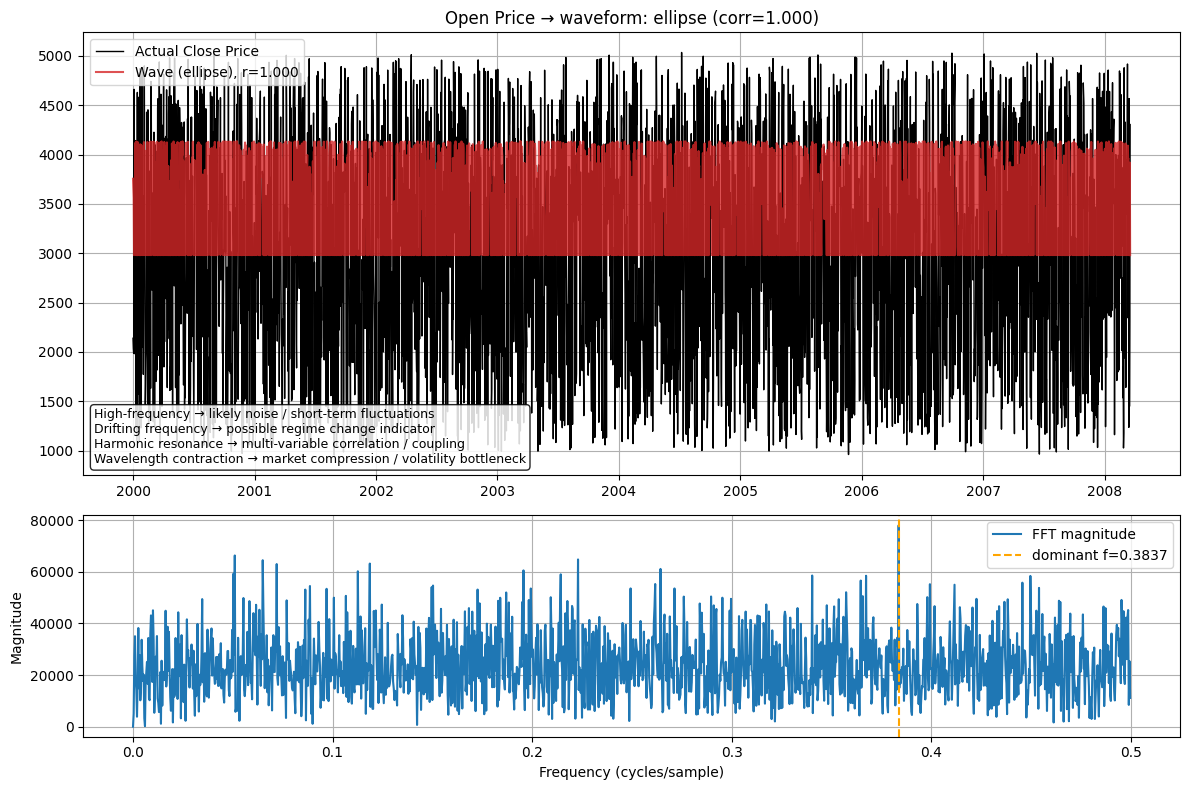

Analyzing feature: High (using column 'Daily High')


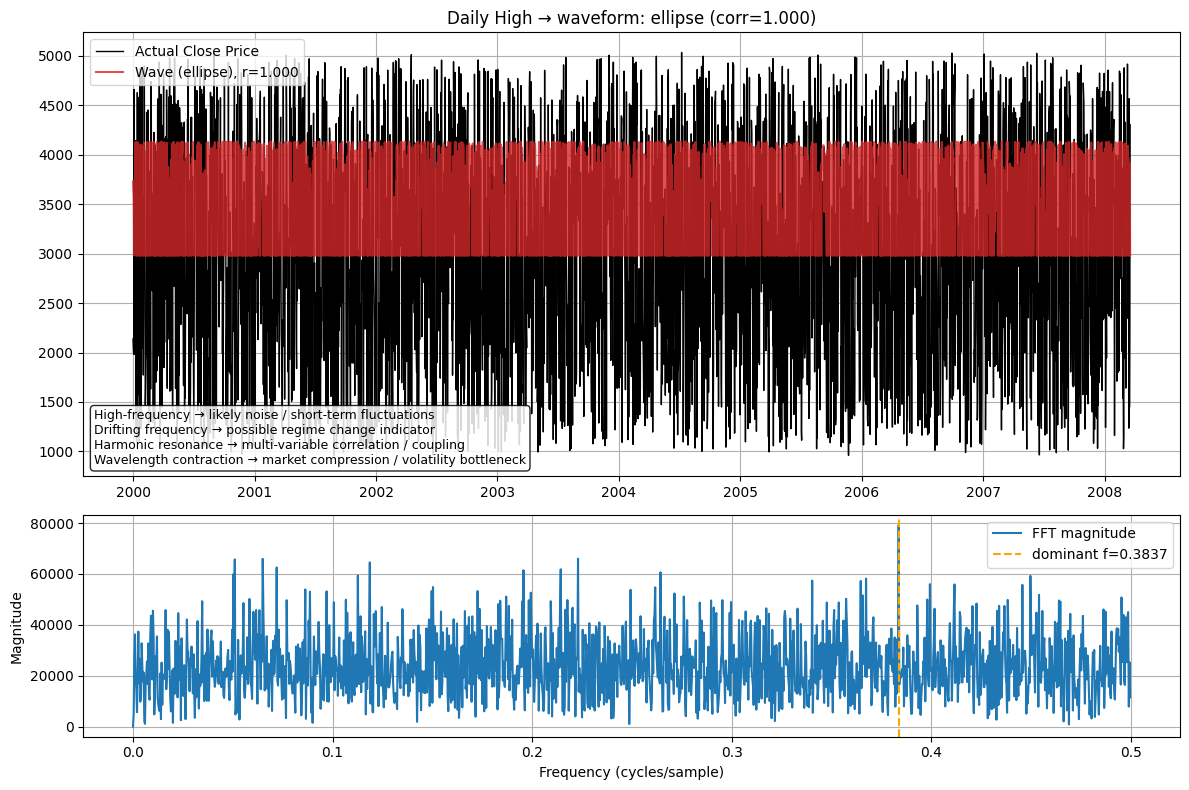

Analyzing feature: Low (using column 'Daily Low')


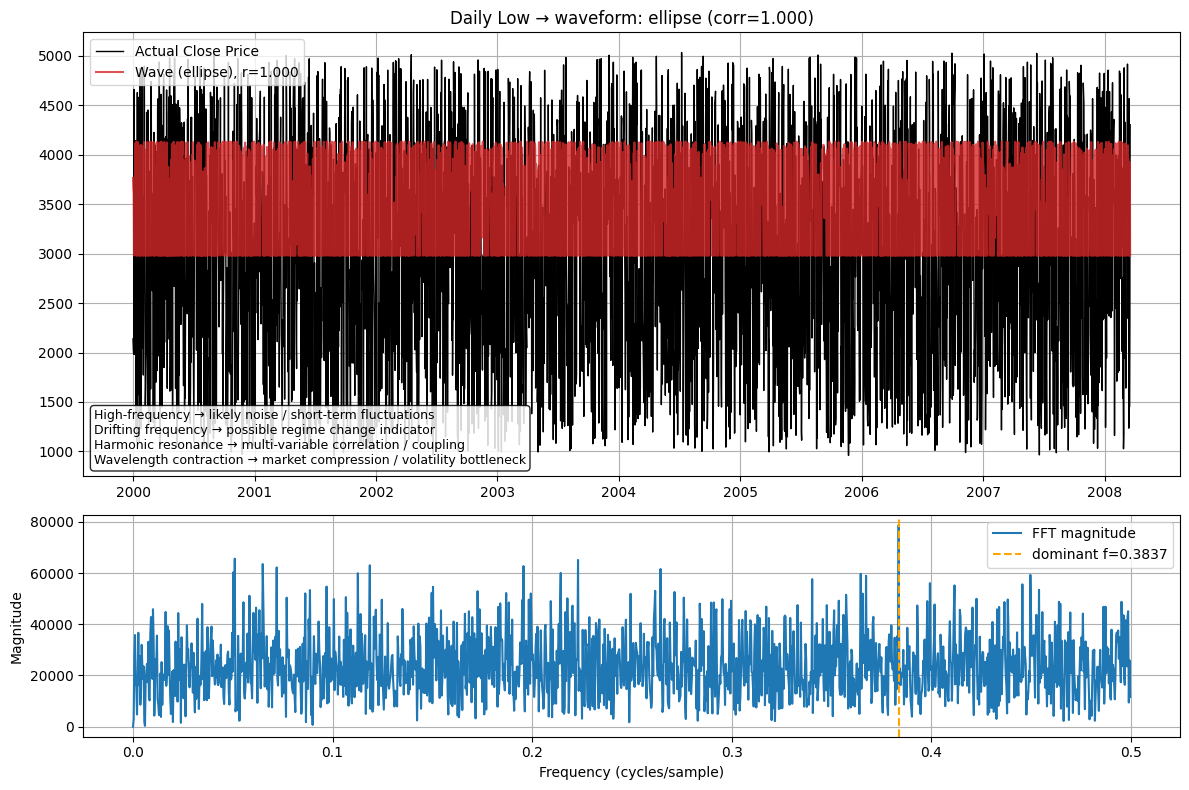

Analyzing feature: Close (using column 'Close Price')


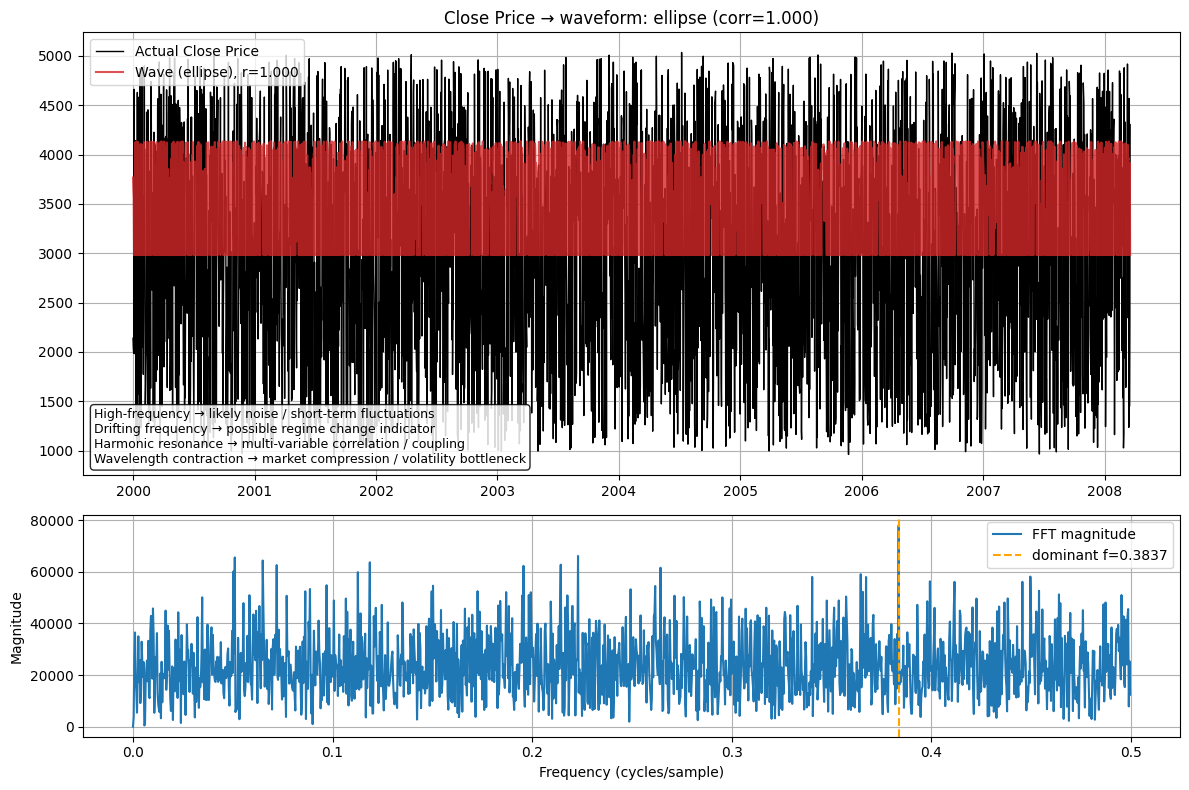

Analyzing feature: Volume (using column 'Trading Volume')


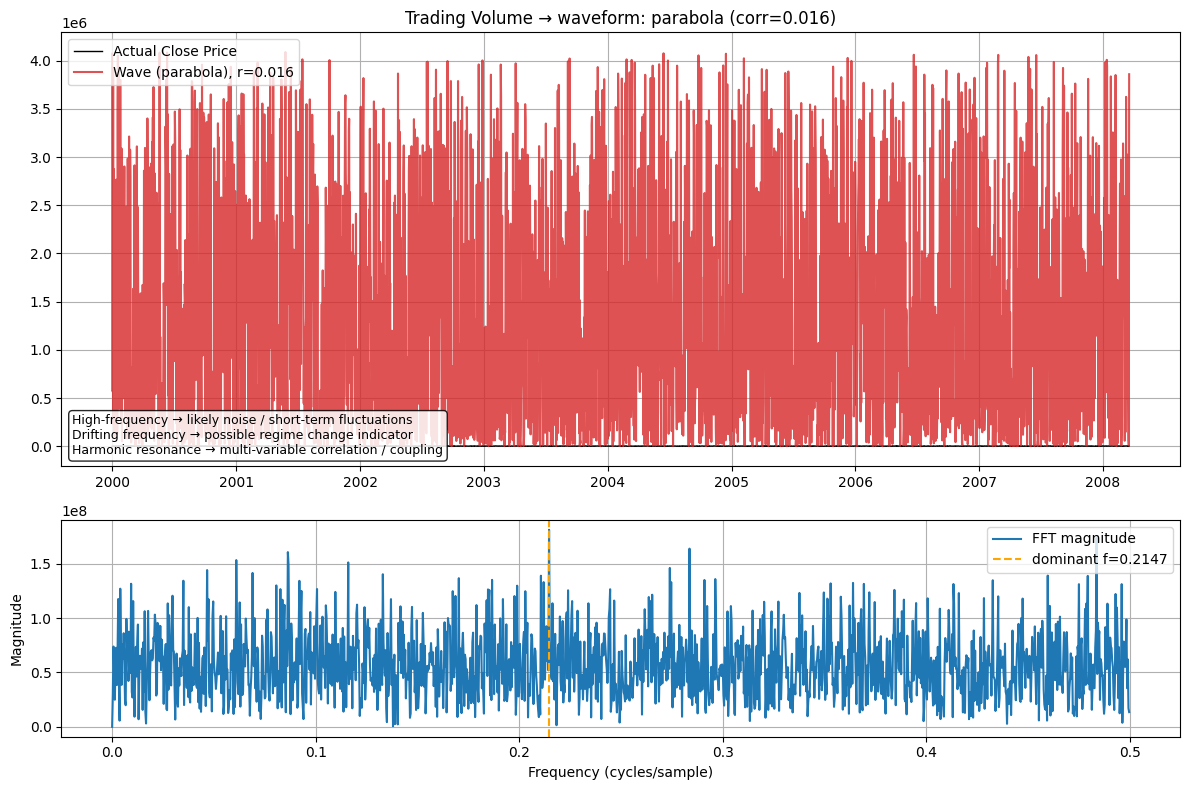

Analyzing feature: GDP Growth (using column 'GDP Growth (%)')


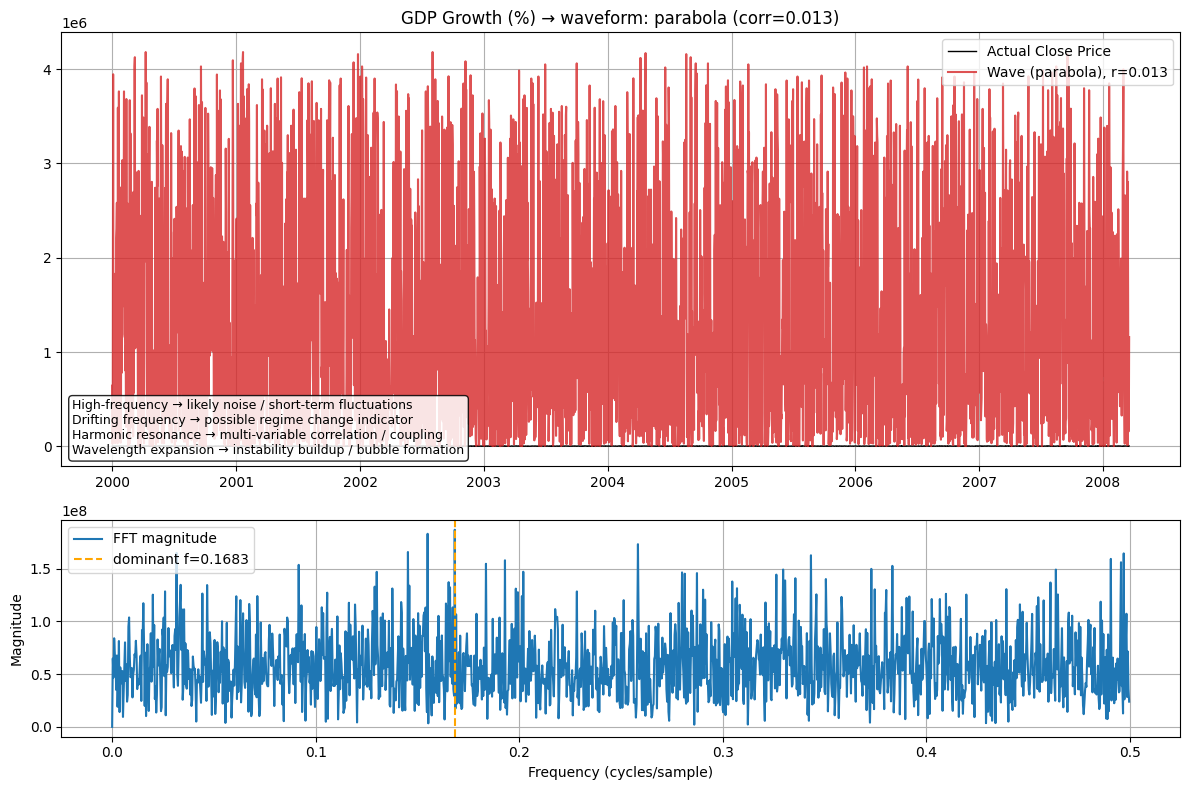

Analyzing feature: Inflation (using column 'Inflation Rate (%)')


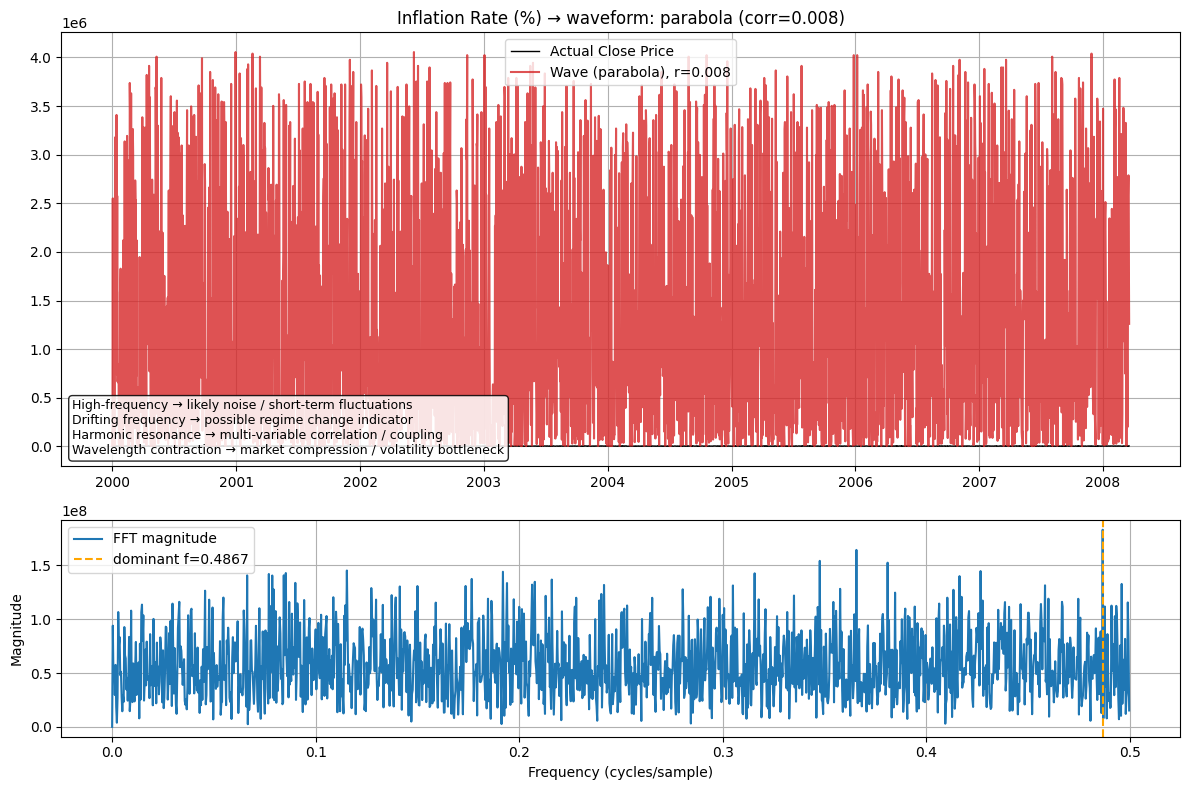

Analyzing feature: Unemployment (using column 'Unemployment Rate (%)')


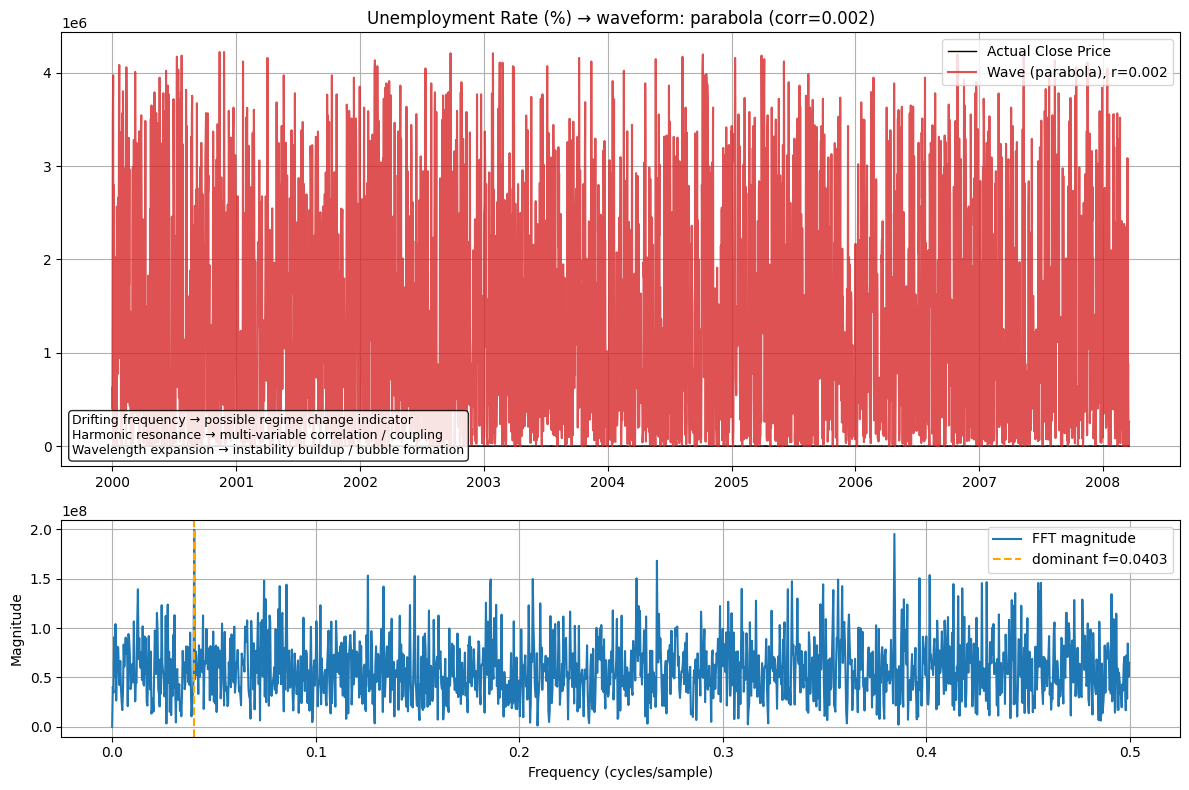

Analyzing feature: Interest Rate (using column 'Interest Rate (%)')


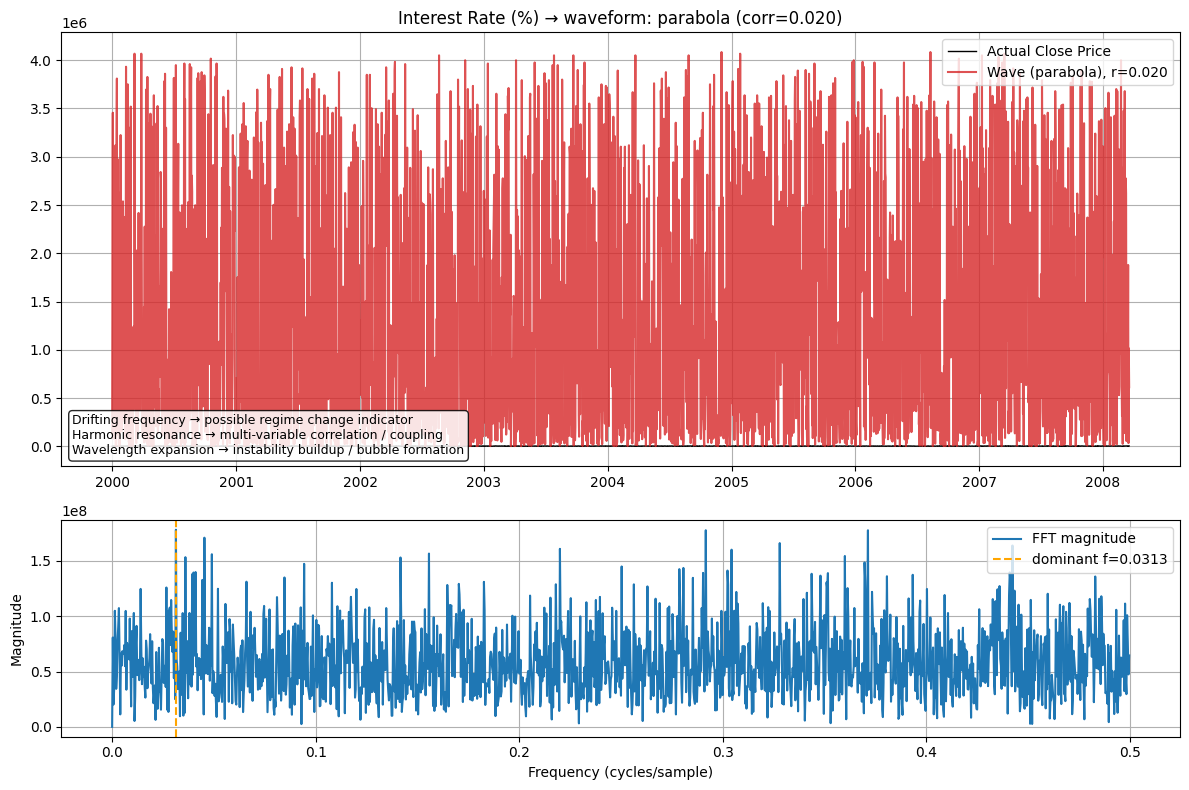

Analyzing feature: Consumer Confidence (using column 'Consumer Confidence Index')


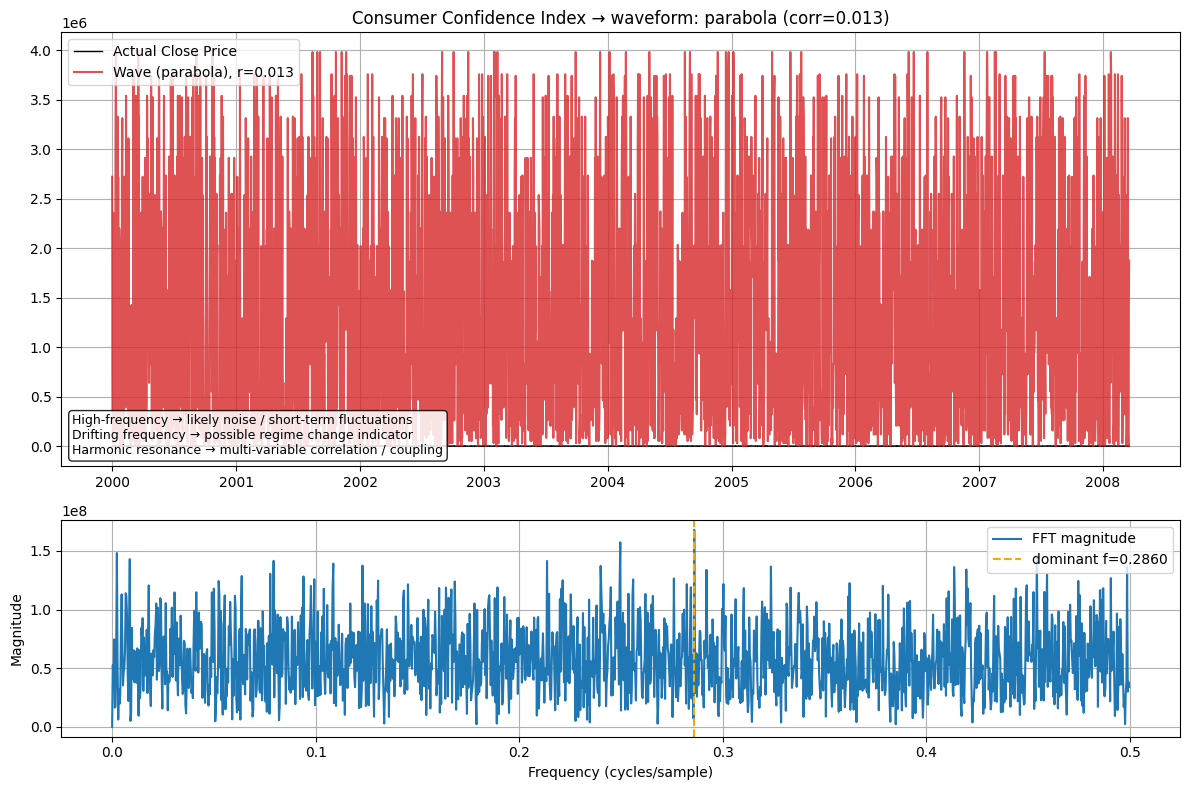

In [38]:
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

selected = []
results = []
for friendly, candidates in col_map.items():
    col = find_col(df, candidates)
    if col is None:
        print(f"WARNING: feature {friendly} not found in df (tried: {candidates}) — skipping")
        continue
    selected.append(col)
    print(f"Analyzing feature: {friendly} (using column '{col}')")
    res = visualize_feature_wave(df, col, target_col='Close Price', outdir='./plots', show=True)
    results.append(res)

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
feature_col = "Open Price"  # replace with any column
target_col = "Close Price"

In [43]:
x = df[feature_col].values
y = df[target_col].values

In [44]:
def ellipse_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    inside = 1 - ((x - mu_x)**2 / (sx**2 + 1e-12))
    inside = np.clip(inside, 0, None)
    return mu_y + sy * np.sqrt(inside)

def parabola_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    return mu_y + (sy**2 / (sx**2 + 1e-12)) * (x - mu_x)**2

def hyperbola_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    outside = (x - mu_x)**2 / (sx**2 + 1e-12) - 1
    wave = np.full_like(x, np.nan, dtype=float)
    mask = outside >= 0
    wave[mask] = mu_y + sy * np.sqrt(outside[mask])
    wave = pd.Series(wave).interpolate(limit_direction='both').values
    return wave


In [45]:
y_ellipse = ellipse_wave(x, y)
y_parabola = parabola_wave(x, y)
y_hyperbola = hyperbola_wave(x, y)

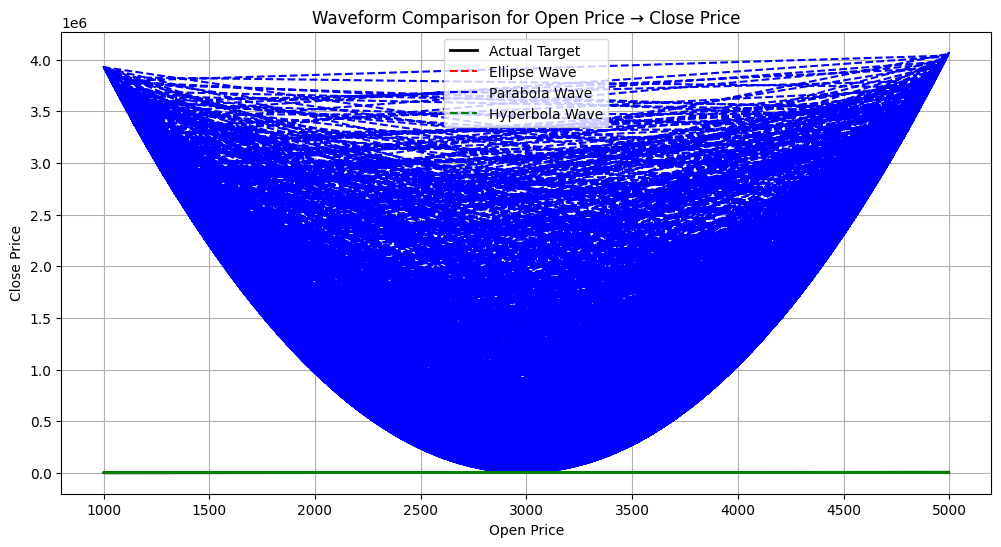

In [46]:
plt.figure(figsize=(12,6))
plt.plot(x, y, label="Actual Target", color="black", linewidth=2)
plt.plot(x, y_ellipse, label="Ellipse Wave", linestyle="--", color="red")
plt.plot(x, y_parabola, label="Parabola Wave", linestyle="--", color="blue")
plt.plot(x, y_hyperbola, label="Hyperbola Wave", linestyle="--", color="green")

plt.xlabel(feature_col)
plt.ylabel(target_col)
plt.title(f"Waveform Comparison for {feature_col} → {target_col}")
plt.legend()
plt.grid(True)
plt.show()

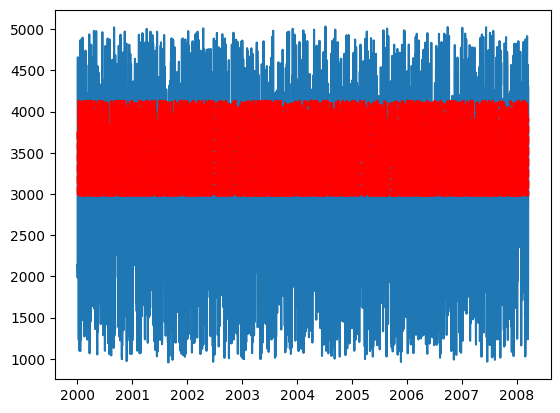

In [ ]:
t = pd.to_datetime(df['Date'], errors='coerce')
y_wave = ellipse_wave(x, y)  
plt.plot(t, y, label="Actual Target")
plt.plot(t, y_wave, label="Ellipse Wave", linestyle='--', color='red')